In [1]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/fc/49/253e8d31a02064d0ff14a8e335d43ea6d60e89bc877c8bdc1fa8f76b5daa/ultralytics-8.3.28-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics-thop>=2.0.0 from https://files.pythonhosted.org/packages/d7/ec/3650362c6cd72f0a2a9d840cbe7a136ceea6e06b02bb7088a4f436accc5c/ultralytics_thop-2.0.11-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 3.4 MB/s eta 0:00:00a 0:00:01m


In [29]:
import pydicom
from PIL import Image
import numpy as np

def dcm_to_jpg(dcm_path, jpg_path):
    # Загрузка DICOM-файла
    dicom_data = pydicom.dcmread(dcm_path)
    
    # Получение пиксельных данных и нормализация
    image_array = dicom_data.pixel_array
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255
    image_array = image_array.astype(np.uint8)

    # Создание изображения в формате PIL
    image = Image.fromarray(image_array)

    # Сохранение изображения в формате JPEG
    image.save(jpg_path, "JPEG")
    print(f"Файл сохранен как {jpg_path}")

dcm_path = "/Users/kirfi/Downloads/LiverProject/PVTFormer/CT/6/DICOM_anon/i0021,0000b.dcm"
jpg_path = "output_image5.jpg"
dcm_to_jpg(dcm_path, jpg_path)


Файл сохранен как output_image5.jpg


In [10]:
import os
import cv2
import numpy as np
import pydicom
from PIL import Image
from tqdm import tqdm
import re

def dcm_to_jpg(dcm_path, jpg_path):
    dicom_data = pydicom.dcmread(dcm_path)
    image_array = dicom_data.pixel_array
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255
    image_array = image_array.astype(np.uint8)
    image = Image.fromarray(image_array)
    image.save(jpg_path, "JPEG")

def get_contours_from_annotation(annotation_path):
    img = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    yolo_coords = []
    for contour in contours:
        points = contour.reshape(-1, 2)
        height, width = img.shape[:2]
        normalized_points = [(x / width, y / height) for x, y in points]
        yolo_coords.append(normalized_points)
    return yolo_coords

def save_yolo_format(contours, output_path):
    with open(output_path, 'w') as f:
        for contour in contours:
            class_id = 0
            contour_str = f"{class_id} " + " ".join([f"{x:.6f} {y:.6f}" for x, y in contour]) + "\n"
            f.write(contour_str)

def extract_annotation_number(filename):
    match = re.search(r"i(\d{4}),\d{4}b", filename)
    if match:
        return f"{int(match.group(1)):03d}"
    
    match = re.search(r"IMG-\d{4}-(\d{5})", filename)
    if match:
        return f"{int(match.group(1)[1:]):03d}"
    
    return None

def process_dataset(root_dir, output_dir):
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
    
    for folder in tqdm(folders, desc="Обработка папок"):
        folder_path = os.path.join(root_dir, folder)
        ground_dir = os.path.join(folder_path, "Ground")
        dicom_dir = os.path.join(folder_path, "DICOM_anon")
        
        dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith(".dcm")]
        
        for filename in tqdm(dicom_files, desc=f"Обработка файлов в {folder}", leave=False):
            annotation_number = extract_annotation_number(filename)
            if annotation_number is None:
                print(f"Не удалось извлечь номер аннотации для файла {filename}")
                continue

            # Формируем имена для JPG и TXT файлов с учетом папки
            base_name = f"liver_GT_{annotation_number}"
            jpg_filename = f"{base_name}_{folder}.jpg"
            txt_filename = f"{base_name}_{folder}.txt"
            
            jpg_path = os.path.join(images_dir, jpg_filename)
            txt_path = os.path.join(labels_dir, txt_filename)
            
            # Преобразование DICOM в JPG
            dcm_path = os.path.join(dicom_dir, filename)
            dcm_to_jpg(dcm_path, jpg_path)
            
            # Обработка файла аннотации
            annotation_path = os.path.join(ground_dir, f"{base_name}.png")
            if os.path.exists(annotation_path):
                contours = get_contours_from_annotation(annotation_path)
                save_yolo_format(contours, txt_path)
            else:
                # Создаем пустой файл TXT, если аннотация не найдена
                open(txt_path, 'w').close()
                print(f"Аннотация не найдена для файла {annotation_path}")


root_dir = "CT"  # корневая папка с DICOM и аннотациями
output_dir = "yolo_dataset"  # папка для сохранения датасета YOLO
process_dataset(root_dir, output_dir)


Обработка файлов в 27:  40%|███████▎          | 98/242 [00:00<00:00, 332.24it/s]

Аннотация не найдена для файла CT/27/Ground/liver_GT_242.png



Обработка файлов в 29:  52%|████████▊        | 111/214 [00:00<00:00, 326.26it/s]

Аннотация не найдена для файла CT/29/Ground/liver_GT_214.png



Обработка папок:  30%|████████                   | 6/20 [00:02<00:05,  2.70it/s]

Аннотация не найдена для файла CT/28/Ground/liver_GT_102.png



Обработка папок:  50%|█████████████             | 10/20 [00:03<00:03,  3.07it/s]

Аннотация не найдена для файла CT/26/Ground/liver_GT_114.png



Обработка папок:  60%|███████████████▌          | 12/20 [00:04<00:03,  2.19it/s]

Аннотация не найдена для файла CT/21/Ground/liver_GT_257.png



Обработка папок:  65%|████████████████▉         | 13/20 [00:05<00:03,  1.83it/s]

Аннотация не найдена для файла CT/30/Ground/liver_GT_266.png



Обработка папок:  70%|██████████████████▏       | 14/20 [00:06<00:02,  2.02it/s]

Аннотация не найдена для файла CT/24/Ground/liver_GT_123.png



Обработка файлов в 23:  76%|████████████▉    | 183/240 [00:00<00:00, 336.01it/s]

Аннотация не найдена для файла CT/23/Ground/liver_GT_240.png



Обработка папок:  95%|████████████████████████▋ | 19/20 [00:07<00:00,  2.78it/s]

Аннотация не найдена для файла CT/22/Ground/liver_GT_101.png



Обработка файлов в 25:  32%|█████▋            | 75/235 [00:00<00:00, 365.58it/s]

Аннотация не найдена для файла CT/25/Ground/liver_GT_235.png



Обработка папок: 100%|██████████████████████████| 20/20 [00:08<00:00,  2.33it/s]


In [ ]:
import os
import shutil

# Исходные пути
base_path = '/Users/kirfi/Downloads/LiverProject/PVTFormer/datasets/yolo_dataset'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

# Пути для новой структуры
new_base_path = '/Users/kirfi/Downloads/LiverProject/PVTFormer/datasets/yolo_dataset_v2'
split_paths = {
    'train': {'images': os.path.join(new_base_path, 'train/images'), 'labels': os.path.join(new_base_path, 'train/labels')},
    'val': {'images': os.path.join(new_base_path, 'val/images'), 'labels': os.path.join(new_base_path, 'val/labels')},
    'test': {'images': os.path.join(new_base_path, 'test/images'), 'labels': os.path.join(new_base_path, 'test/labels')}
}

# Создание структуры папок
for split in split_paths:
    os.makedirs(split_paths[split]['images'], exist_ok=True)
    os.makedirs(split_paths[split]['labels'], exist_ok=True)

# Критерии для val и test
val_suffixes = ('_1', '_10', '_16', '_23')
test_suffixes = ('_8', '_6', '_21', '_19')

# Функция для определения набора
def determine_split(filename):
    if filename.endswith(val_suffixes):
        return 'val'
    elif filename.endswith(test_suffixes):
        return 'test'
    else:
        return 'train'

# Перемещение файлов
for filename in os.listdir(images_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        split = determine_split(filename.split('.')[0])
        shutil.move(os.path.join(images_path, filename), os.path.join(split_paths[split]['images'], filename))
        
        # Перемещение соответствующего файла меток
        label_file = filename.rsplit('.', 1)[0] + '.txt'
        if os.path.exists(os.path.join(labels_path, label_file)):
            shutil.move(os.path.join(labels_path, label_file), os.path.join(split_paths[split]['labels'], label_file))


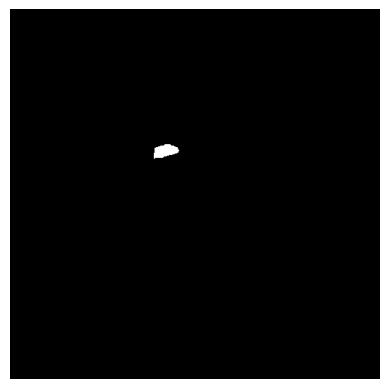

In [3]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Загрузка изображения
image_path = "CT/1/Ground/liver_GT_004.png"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# Загрузка файла разметки
label_path = "output.txt"
image_width, image_height = image.size

# Чтение и обработка разметки
with open(label_path, 'r') as file:
    for line in file:
        data = line.split()
        class_id = int(data[0])
        coordinates = list(map(float, data[1:]))

        # Преобразование нормализованных координат в пиксели
        pixel_coordinates = []
        for i in range(0, len(coordinates), 2):
            x = int(coordinates[i] * image_width)
            y = int(coordinates[i + 1] * image_height)
            pixel_coordinates.append((x, y))

        # Рисование контура
        draw.line(pixel_coordinates, fill="red", width=2)
        
        draw.line([pixel_coordinates[-1], pixel_coordinates[0]], fill="red", width=2)

plt.imshow(image)
plt.axis("off")
plt.show()


In [15]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-seg.pt")

# Train the model
train_results = model.train(
    data="liver.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device="mps",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image

New https://pypi.org/project/ultralytics/8.3.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.28 🚀 Python-3.11.5 torch-2.1.1 MPS (Apple M2 Pro)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=liver.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sav

train: Scanning /Users/kirfi/Downloads/LiverProject/PVTFormer/datasets/yolo_data

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/kirfi/Downloads/LiverProject/PVTFormer/datasets/yolo_datase

Plotting labels to runs/segment/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.37G     0.9614      1.825      2.109      1.181         11   
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

KeyboardInterrupt

